**Pipeline**

Collect Sequences in FASTA format from NCBI

V

Reformat the header here --> (30 lines of code)

V

Put .fa file into CLUSTAL-W for sequence alignment

V

Put aligned .fa files into HMM

V

Collect .tsv files for training and test data and combine into one .tsv  


V

Data Analysis

# Reformatting Header NCBI FASTA

Goal: I want Genus  + sp. is in front for MSA. Will use File IO to ensure the Genus_species is one line, remove it from wherever it found it, and move it to the front. spaghetti

In [ ]:
import os

# FILE IO  with file names
input_file = input("Please enter the name of the input file (include the file type extension): ").strip()
output_file = input("PLease enter the name of the output file (include the file type extension): ").strip()
output_folder = input("Please enter the name of the folder to save the output file: ").strip()
#exceptions handling in case I miss the file ehehe one more time >:(
try:
  with open(input_file, 'r') as file:
    data = file.read()
except FileNotFoundError:
  print("Oopsie: The file was not found.")
  exit()

# Ensure the folder exists that the user wants to add file, if not create it
if not os.path.exists(output_folder):
  os.makedirs(output_folder)
  print(f"Folder '{output_folder}' created.")

# explicitly creating the full path for the output file
output_path = os.path.join(output_folder, output_file)

#Split at the start of '>'
sequences = [seq for seq in data.split('>') if seq.strip()]
#Initialize a list for reformatted sequences
reformatted_sequences = []
# loop thorugh file, split at header, delete Genus sp. and replace in front
for seq in sequences:
  parts = seq.split('\n', 1) #slipt at new line
  header = parts[0].strip()  #just the header
  sequence = parts[1].strip() if len(parts) > 1 else "" #seq to put back later
  #conditionals
  if "[" in header and "]" in header:
    genus_species = header[header.index("[") + 1:header.index("]")]
    genus_species = genus_species.replace(" ", "_")  # Replace spaces w/ underscores sp one word for MSA
    header_without_genus_species = header.replace(f"[{genus_species.replace('_', ' ')}]", "").strip()
    new_header = f"[{genus_species}] {header_without_genus_species}"
    # Put it back together
    reformatted_sequences.append(f">{new_header}\n{sequence}")
#Save as new file in user defined folder.
with open(output_path, 'w') as file:
  file.write("\n".join(reformatted_sequences) + "\n")
print(f"Reformatted sequences have been saved to '{output_path}'.")

#Future note, see if i can recreate this as bash shell script

# Alignment Seqs in of CLUSTAL-W

In [ ]:
#Installing CLUSTAL-W here so I can just do stright alignment here
!sudo apt-get install clustalw -y

In [ ]:
import os
from google.colab import files

# output and clustal's folders
input_folder = input("Enter the path to the folder containing your fasta files (ie. /content/folder): ").strip()
aligned_folder = input("Enter the path to the output folder (ie. /content/aligned_results): ").strip()

os.makedirs(aligned_folder, exist_ok=True)


# run all .fa files in the input folder via a loop
for filename in os.listdir(input_folder):
  if filename.endswith(".fa"):  # Only process .fa files
    input_path = os.path.join(input_folder, filename)
    output_file = filename.replace(".fa", "_aligned.fa")
    output_path = os.path.join(aligned_folder, output_file)
    os.system(f"clustalw-INFILE={input_path}-OUTFILE={output_path}-OUTPUT=FASTA")
    print(f"Alignment completed for {filename}. Output saved as {output_path}")
for aligned_file in os.listdir(aligned_folder):
    aligned_path = os.path.join(aligned_folder, aligned_file)
    files.download(aligned_path)
print("Alignment complete. The files downloaded. Proceed to next step and upload aligned seqs into HMM.")

Enter the path to the folder containing your fasta files (ie. /content/folder): /content/Reformatted
Enter the path to the output folder (ie. /content/aligned_results): /content/Aligned Seqs
Alignment completed for psychrophilic(TRAIN).fa. Output saved as /content/Aligned Seqs/psychrophilic(TRAIN)_aligned.fa
Alignment completed for psychrophilic(TEST+TRAIN).fa. Output saved as /content/Aligned Seqs/psychrophilic(TEST+TRAIN)_aligned.fa
Alignment completed for psychrophilic(TEST).fa. Output saved as /content/Aligned Seqs/psychrophilic(TEST)_aligned.fa
Alignment completed. Preparing files for download...
Files downloaded, please upload aligned seqs into HMM.


# Combining .TSV Files from HMM  into 1 single EXCEL SHEET

In [ ]:
!pip install xlsxwriter

In [ ]:
import os
import pandas as pd

# user input the folder path
folder_path = input("Please enter the full path to the folder containing .tsv files: ").strip()

# Validate the folder path
if not os.path.exists(folder_path):
    print("File not found.")
else:
  # Using list comprehnsion to list all .tsv files in the folder
  tsv_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(".tsv")]
  if not tsv_files:
    print("No .tsv files found in the specified folder!!!!")
  else:
    output_excel_path = "combined_output.xlsx"
    with pd.ExcelWriter(output_excel_path, engine="xlsxwriter") as writer:
      for file_path in tsv_files:
        sheet_name = os.path.basename(file_path).replace(".tsv", "")
        df = pd.read_csv(file_path, sep='\t')
        df.to_excel(writer, sheet_name=sheet_name, index=False)
        print("Added data to sheet")

    print("Excel file saved at:", {output_excel_path})



Please enter the full path to the folder containing .tsv files: /content/TSV_VITERBI
Added data to sheet
Added data to sheet
Added data to sheet
Added data to sheet
Added data to sheet
Added data to sheet
Excel file saved at: {'combined_output.xlsx'}


# Data Analysis


In [ ]:
from google.colab import files
import pandas as pd
file_name = "Raw Data (1).xlsx"
data = pd.read_excel(file_name)

# Box and Whisker Plots
https://seaborn.pydata.org/generated/seaborn.boxplot.html

This is used to see the overall distribution of each test data set in each therophillic or psychrophillic HMM and how this stacks up to the viterbi scores calucalted in the trainig sets.

<ipython-input-46-9f8047b56f7c>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot1_data,x="Group",y="Viterbi_Score",palette="Set2")


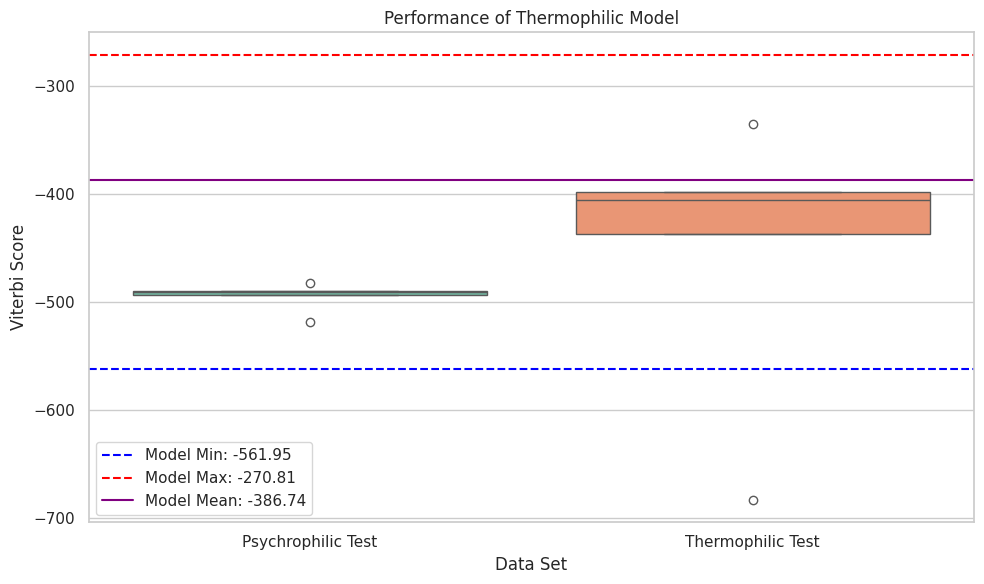

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# needed to make column names and values the same for data processing a
data.columns = ["Organism", "Viterbi_Score", "Data_Set", "Model", "Sequence", "Length"]
data["Data_Set"] = data["Data_Set"].str.strip().str.lower()
data["Model"] = data["Model"].str.strip().str.lower()
# plot 1 sets
thermo_test_thermo_model = data[(data["Data_Set"] == "thermophilic test") & (data["Model"] == "thermophilic")]
psychro_test_thermo_model = data[(data["Data_Set"] == "psychrophilic test") & (data["Model"] == "thermophilic")]

# data for Plot 1
plot1_data = pd.concat([psychro_test_thermo_model.assign(Group="Psychrophilic Test"), thermo_test_thermo_model.assign(Group="Thermophilic Test")])

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# boxplot
sns.boxplot(data=plot1_data,x="Group",y="Viterbi_Score",palette="Set2")

# the min, max, and mean for the Thermophilic Model
thermo_model_data = data[data["Data_Set"] == "thermophilic training"]["Viterbi_Score"]
min_val = thermo_model_data.min()
max_val = thermo_model_data.max()
mean_val = thermo_model_data.mean()
plt.axhline(min_val, color="blue", linestyle="--", label=f"Model Min: {min_val:.2f}")
plt.axhline(max_val, color="red", linestyle="--", label=f"Model Max: {max_val:.2f}")
plt.axhline(mean_val, color="purple", linestyle="-", label=f"Model Mean: {mean_val:.2f}")
# Add titles and labels
plt.title("Performance of Thermophilic Model")
plt.xlabel("Data Set")
plt.ylabel("Viterbi Score")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

<ipython-input-47-f63bfbebdbd2>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot2_data,x="Group",y="Viterbi_Score",palette="Set2")


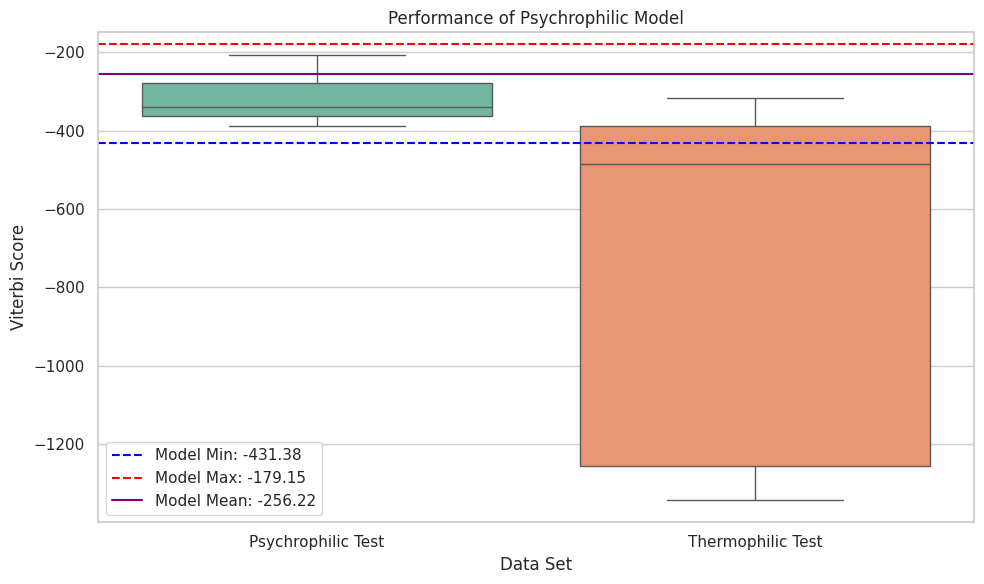

In [ ]:
# plot 2, same deal as above.
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

thermo_test_psychro_model = data[(data["Data_Set"] == "thermophilic test") & (data["Model"] == "psychrophilic")]
psychro_test_psychro_model = data[(data["Data_Set"] == "psychrophilic test") & (data["Model"] == "psychrophilic")]

plot2_data = pd.concat([psychro_test_psychro_model.assign(Group="Psychrophilic Test"),thermo_test_psychro_model.assign(Group="Thermophilic Test")])
#the boxplot
sns.boxplot(data=plot2_data,x="Group",y="Viterbi_Score",palette="Set2")

# Calculate the min, max, and mean for the Psychrophilic Model
psychro_model_data = data[data["Data_Set"] == "psychrophilic training"]["Viterbi_Score"]
min_val = psychro_model_data.min()
max_val = psychro_model_data.max()
mean_val = psychro_model_data.mean()

# Add lines for min, max, and mean
plt.axhline(min_val, color="blue", linestyle="--", label=f"Model Min: {min_val:.2f}")
plt.axhline(max_val, color="red", linestyle="--", label=f"Model Max: {max_val:.2f}")
plt.axhline(mean_val, color="purple", linestyle="-", label=f"Model Mean: {mean_val:.2f}")

# Add titles and labels
plt.title("Performance of Psychrophilic Model")
plt.xlabel("Data Set")
plt.ylabel("Viterbi Score")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

# Confusion Matrix and ROC curves
https://scikit-learn.org/dev/modules/generated/sklearn.metrics.roc_curve.html
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html


This denotes the probabily that at a certain threshold, what is the probabilty that a sequcnes get categorizes correctly or incorrectly. As well as is the threshold that we categorize at optimal? Using ROC curves.  

Classification Threshold for Thermophilic Model: -482.6023197


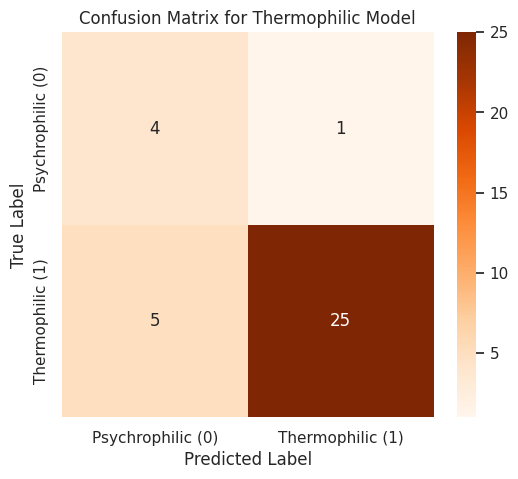

In [ ]:
from sklearn.metrics import confusion_matrix
thermo_model_threshold = data[(data["Data_Set"] == "psychrophilic test") & (data["Model"] == "thermophilic")]["Viterbi_Score"].max()
print("Classification Threshold for Thermophilic Model:", thermo_model_threshold)
data["Predicted_Label_Thermo"] = (data["Viterbi_Score"] >= thermo_model_threshold).astype(int)

# Confusion Matrix for Thermophilic Model
thermo_data = data[data["Model"] == "thermophilic"]  # ONLY thermophilic model data, total 35 samples
true_labels_thermo = thermo_data["Data_Set"].apply(lambda x: 1 if "thermophilic" in x else 0)
cm_thermo = confusion_matrix(true_labels_thermo, thermo_data["Predicted_Label_Thermo"])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_thermo, annot=True, fmt="d", cmap="Oranges",xticklabels=["Psychrophilic (0)", "Thermophilic (1)"],yticklabels=["Psychrophilic (0)", "Thermophilic (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Thermophilic Model")
plt.show()

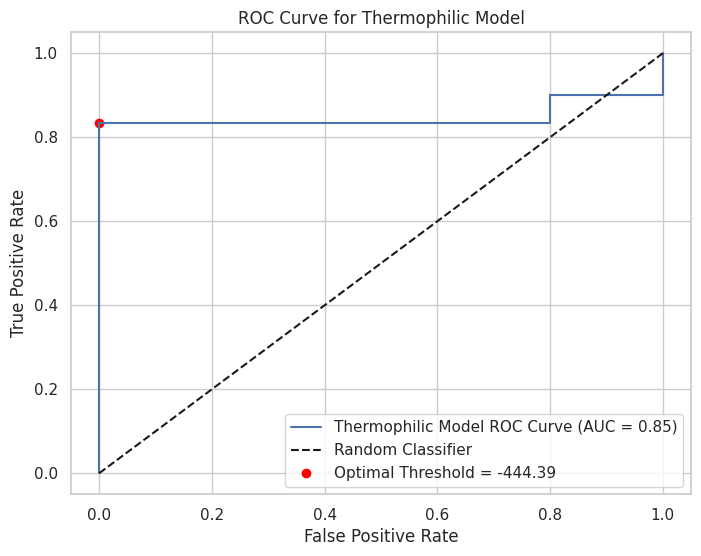

Optimal Threshold for Thermophilic Model (based on ROC): -444.385874175701


In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
# Generate ROC curve data for the Thermophilic Model
fpr_thermo, tpr_thermo, thresholds_thermo = roc_curve(true_labels_thermo, thermo_data["Viterbi_Score"], pos_label=1)
# Calculate AUC for the Thermophilic Model
auc_thermo = roc_auc_score(true_labels_thermo, thermo_data["Viterbi_Score"])
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_thermo, tpr_thermo, label=f"Thermophilic Model ROC Curve (AUC = {auc_thermo:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")  # Random classifier diagonal
optimal_idx_thermo = np.argmax(tpr_thermo - fpr_thermo)
optimal_threshold_thermo = thresholds_thermo[optimal_idx_thermo]
plt.scatter(fpr_thermo[optimal_idx_thermo], tpr_thermo[optimal_idx_thermo], color="red", label=f"Optimal Threshold = {optimal_threshold_thermo:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Thermophilic Model")
plt.legend(loc="lower right")
plt.show()

# Print optimal threshold
print("Optimal Threshold for Thermophilic Model (based on ROC):", optimal_threshold_thermo)


Classification Threshold for Psychrophilic Model: -431.3793578


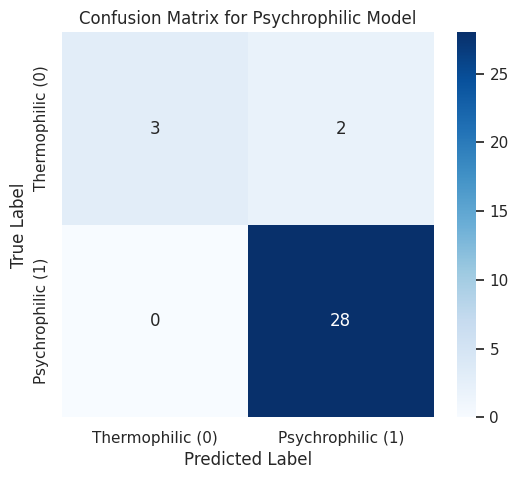

In [ ]:
psychro_model_threshold = data[(data["Data_Set"] == "psychrophilic training") & (data["Model"] == "psychrophilic")]["Viterbi_Score"].min()
print("Classification Threshold for Psychrophilic Model:", psychro_model_threshold)
# Apply predicted labels for Psychrophilic Model
data["Predicted_Label_Psychro"] = (data["Viterbi_Score"] >= psychro_model_threshold).astype(int)

# ONLY Psychrophilic model data
psychro_data = data[data["Model"] == "psychrophilic"]
# applying labels for Psychrophilic samples
true_labels_psychro = psychro_data["Data_Set"].apply(lambda x: 1 if "psychrophilic" in x else 0)
cm_psychro = confusion_matrix(true_labels_psychro, psychro_data["Predicted_Label_Psychro"])

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_psychro, annot=True, fmt="d", cmap="Blues",xticklabels=["Thermophilic (0)", "Psychrophilic (1)"],yticklabels=["Thermophilic (0)", "Psychrophilic (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Psychrophilic Model")
plt.show()


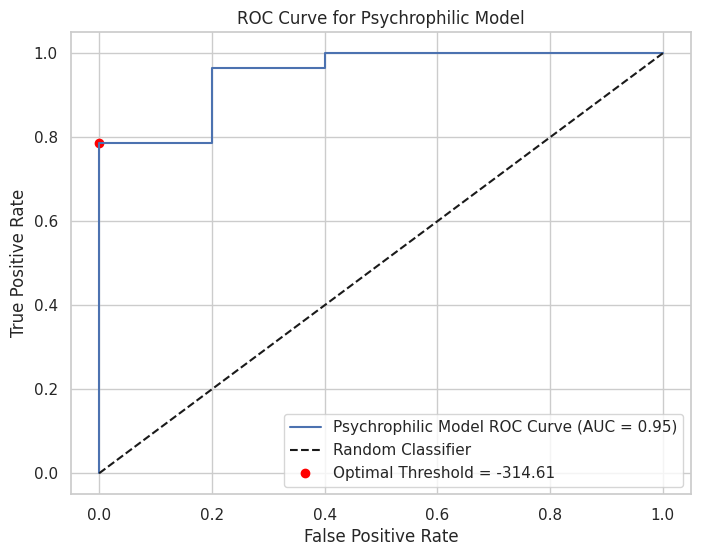

Optimal Threshold for Psychrophilic Model (based on ROC): -314.6095494


In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

# ROC curve data for the Psychrophilic Model
fpr_psychro, tpr_psychro, thresholds_psychro = roc_curve(true_labels_psychro, psychro_data["Viterbi_Score"], pos_label=1)
auc_psychro = roc_auc_score(true_labels_psychro, psychro_data["Viterbi_Score"])
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_psychro, tpr_psychro, label=f"Psychrophilic Model ROC Curve (AUC = {auc_psychro:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")  # Random classifier diagonal
optimal_idx_psychro = np.argmax(tpr_psychro - fpr_psychro)  # Optimal threshold point
optimal_threshold_psychro = thresholds_psychro[optimal_idx_psychro]
plt.scatter(fpr_psychro[optimal_idx_psychro], tpr_psychro[optimal_idx_psychro], color="red", label=f"Optimal Threshold = {optimal_threshold_psychro:.2f}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Psychrophilic Model")
plt.legend(loc="lower right")
plt.show()

# Print optimal threshold
print("Optimal Threshold for Psychrophilic Model (based on ROC):", optimal_threshold_psychro)
